In [84]:
import math
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn

In [85]:
def sample_covariance(neuron_one, trainpoint_one, neuron_two, trainpoint_two, yy):
    '''Sample covariance, formulas as in https://en.wikipedia.org/wiki/Sample_mean_and_covariance'''
    one = yy[:, neuron_one-1, trainpoint_one-1]
    two = yy[:, neuron_two-1, trainpoint_two-1]
    cov = np.cov(one, two)[0, 1]

    return cov

def G_xx(inbound_one, inbound_two, cbn, cwn):
    '''Calculation of metrics of type (4.8) and (4.36)'''
    return cbn + cwn*inbound_one.dot(inbound_two)/len(inbound_one)


In [86]:
class FeedForwardNet(nn.Module):

    def __init__(self, n0=3, nk=10, nl=3, l=3, bias_on=False):
        '''n0: # dimension of x
           nk: # hidden nodes
           nl: # dimension of y
           l: # number of layers
           bias_on: # whether bias is included into linear preactivations'''
        if l < 2:
            raise Exception("FFN must have at least two layers")
        super().__init__()
        self.n0=n0
        self.nk=nk
        self.nl=nl
        self.bias_on = bias_on
        self.log_level = None
        self.hidden_linears = []
        self.output_linear = None
        # assume layer-independent cb and cw
        self.cb, self.cw = None, None
        print("FeedForwardNet created with n0={}, nk={}, nl={}, l={}, bias_on={}".format(n0, nk, nl, l, bias_on))

        self.hidden_linears.append(nn.Linear(n0, nk, bias=bias_on))
        if l > 2:
            for _ in range(2, l):
                self.hidden_linears.append(nn.Linear(nk, nk, bias=bias_on))
        self.output_linear = nn.Linear(nk, nl, bias=bias_on)

    def set_log_level(self, value):
        self.log_level = value

    def get_log_level(self):
        if self.log_level in ("debug", "info", "warning", "error"):
            return self.log_level
        else:
            return "info"

    def init_weights(self, cb=0.0, cw=1.0):
        if self.get_log_level() == "debug":
            print("FeedForwardNet weights initialisation with cb={}, cw={}".format(cb, cw))

        #Weight initialisation as in 2.19, 2.20
        self.cb, self.cw = cb, cw
        n_prev = self.n0
        for linear in self.hidden_linears:
            init_linear_weights(linear, self.bias_on, math.sqrt(cb), math.sqrt(cw/n_prev))
            n_prev = linear.weight.size()[0]

        init_linear_weights(self.output_linear, self.bias_on, math.sqrt(cb), math.sqrt(cw/n_prev))

def init_linear_weights(linear, bias_on, std_b=1.0, std_w=1.0):
    nn.init.normal_(linear.weight, mean = 0., std = std_w)
    n_prev = linear.weight.size()[0]
    if bias_on:
        nn.init.normal_(linear.bias, mean = 0., std = std_b)

In [87]:
class ParametricReLUNet(FeedForwardNet):
    def __init__(self, n0=3, nk=10, nl=3, l=3, bias_on=False):
        super().__init__(n0, nk, nl, l, bias_on)
        self.GXX = None  # record the flow of metric G (of type 4.8 and 4.36)
        self.g_indices = None # trainpoint-indices for the flow to record
        self.slope_positive = None
        self.slope_negative = None

    def set_slopes(self, slope_positive = 1.0, slope_negative = 0.25):
        self.slope_positive = slope_positive
        self.slope_negative = slope_negative

    def PReLU(self, input: Tensor) -> Tensor:
        # for pos in range(input.size(dim=0)):
        #     input[pos] = input[pos] * (self.slope_positive if input[pos] >= 0 else self.slope_negative)
        input = torch.where(input >= 0, self.slope_positive * input, self.slope_negative * input)
        return input

    #g_indices is an array of tuples of size number_of_index_pairs_to_track
    def set_gmetric_recording_indices(self, g_indices):
        self.g_indices = g_indices

    def forward(self, xx):
        if self.slope_positive == None:
            raise Exception("To use forward set slopes with call ParametricReLUNet.set_slopes(...)")

        if self.g_indices != None:
            self.GXX = dict.fromkeys(self.g_indices, None)

        #1st dimension-trainset size, 2nd dimension-layer width
        zk = torch.tensor(xx.transpose(), dtype=torch.float32)
        if self.g_indices != None:
            self.record_gmetric(zk)

        for linear in self.hidden_linears:
            zk = linear(zk)
            zk = self.PReLU(zk)
            if self.g_indices != None:
                self.record_gmetric(zk)

        zk = self.output_linear(zk)
        #if self.g_indices != None:
        #    self.record_gmetric(zk)

        return zk.detach().numpy().transpose()

    def record_gmetric(self, zk):
        zk_ = zk.detach().numpy()
        for key, values in self.GXX.items():
            if values == None:
                values = []
                self.GXX[key] = values
            (index_one, index_two) = key
            values.append(G_xx(zk_[index_one-1], zk_[index_two-1], self.cb, self.cw))

    def get_gmetric(self, index_one, index_two):
        try:
            return self.GXX[(index_one, index_two)]
        except KeyError:
            if self.get_log_level() in ("debug", "info"):
                print("gmetric for indices {} and {} not found".format(index_one, index_two))
            return []


In [88]:
#Test for PReLU-activation implementation

testPReLU = ParametricReLUNet()
testPReLU.set_slopes(0.5, 0.2)
resultPReLU = testPReLU.PReLU(torch.tensor(np.array([1.1,-2.2]), dtype=torch.float32))
print(resultPReLU)

FeedForwardNet created with n0=3, nk=10, nl=3, l=3, bias_on=False
tensor([ 0.5500, -0.4400])


In [89]:
'''n0: # dimension of x
    nk: # hidden nodes
    nl: # dimension of y
    l: # number of layers
    nd: # number of points in train-set'''
n0,nk,nl,l=3,10000,2,10
nd = 2
'''slope_plus, slope_minus: # slopes for Relu
    experiments_number: # number of experiments'''
slope_plus, slope_minus=1.0, 0.5
experiments_number = 50

testNet = ParametricReLUNet(n0=n0,nk=nk,nl=nl,l=l)
testNet.set_log_level("info")
testNet.set_slopes(slope_plus, slope_minus)
testNet.set_gmetric_recording_indices([(1,1),(1,2),(2,2)])

xx = np.random.normal(size=(n0, nd)).astype(np.float32)
yy = np.zeros((experiments_number, nl, nd))
#weights distribution variances are set as in (5.67)
cb, cw = 0, 2.0/(slope_plus**2.0 + slope_minus**2.0)

G01_records = []
G00_records = []
G11_records = []

#for each experiment re-initialisation of the weights with recalculation
for experiment_number in range(experiments_number):
    testNet.init_weights(cb, cw)
    res = testNet.forward(xx)
    yy[experiment_number] = res
    G00_records.append(testNet.get_gmetric(1,1).copy())
    G11_records.append(testNet.get_gmetric(2,2).copy())
    G01_records.append(testNet.get_gmetric(1,2).copy())
    
    print('-', end='')


FeedForwardNet created with n0=3, nk=10000, nl=2, l=10, bias_on=False
--------------------------------------------------

In [90]:
for neuron1 in range(1, nl+1):
      for neuron2 in range(neuron1, nl+1):
            for trainpoint1 in range(1, nd+1):
                  for trainpoint2 in range(1 if neuron1 != neuron2 else trainpoint1, nd+1):
                        print("Sample covariance between neuron {}, trainpoint {} and neuron {}, trainpoint {}: {}"\
                              .format(neuron1, trainpoint1, neuron2, trainpoint2\
                                      , sample_covariance(neuron1,trainpoint1,neuron2,trainpoint2,yy)))

Sample covariance between neuron 1, trainpoint 1 and neuron 1, trainpoint 1: 2.164929120612311
Sample covariance between neuron 1, trainpoint 1 and neuron 1, trainpoint 2: 0.5279644556624701
Sample covariance between neuron 1, trainpoint 2 and neuron 1, trainpoint 2: 0.9288778245314383
Sample covariance between neuron 1, trainpoint 1 and neuron 2, trainpoint 1: -0.2669599287738604
Sample covariance between neuron 1, trainpoint 1 and neuron 2, trainpoint 2: 0.12153255390265127
Sample covariance between neuron 1, trainpoint 2 and neuron 2, trainpoint 1: -0.10242025817651444
Sample covariance between neuron 1, trainpoint 2 and neuron 2, trainpoint 2: -0.0759237267979066
Sample covariance between neuron 2, trainpoint 1 and neuron 2, trainpoint 1: 2.657070485942216
Sample covariance between neuron 2, trainpoint 1 and neuron 2, trainpoint 2: 0.3937877891930742
Sample covariance between neuron 2, trainpoint 2 and neuron 2, trainpoint 2: 1.0100539647307718


In [91]:
for trainpoint1 in range(1, nd+1):
    for trainpoint2 in range(trainpoint1, nd+1):
        print("Metric (4.8) for trainpoint {} and trainpoint {}: {}"\
              .format(trainpoint1, trainpoint2, G_xx(xx[:,trainpoint1-1], xx[:,trainpoint2-1], cb, cw)))

Metric (4.8) for trainpoint 1 and trainpoint 1: 2.275131988525391
Metric (4.8) for trainpoint 1 and trainpoint 2: -0.35045871734619144
Metric (4.8) for trainpoint 2 and trainpoint 2: 0.8294417063395182


In [92]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'G01')

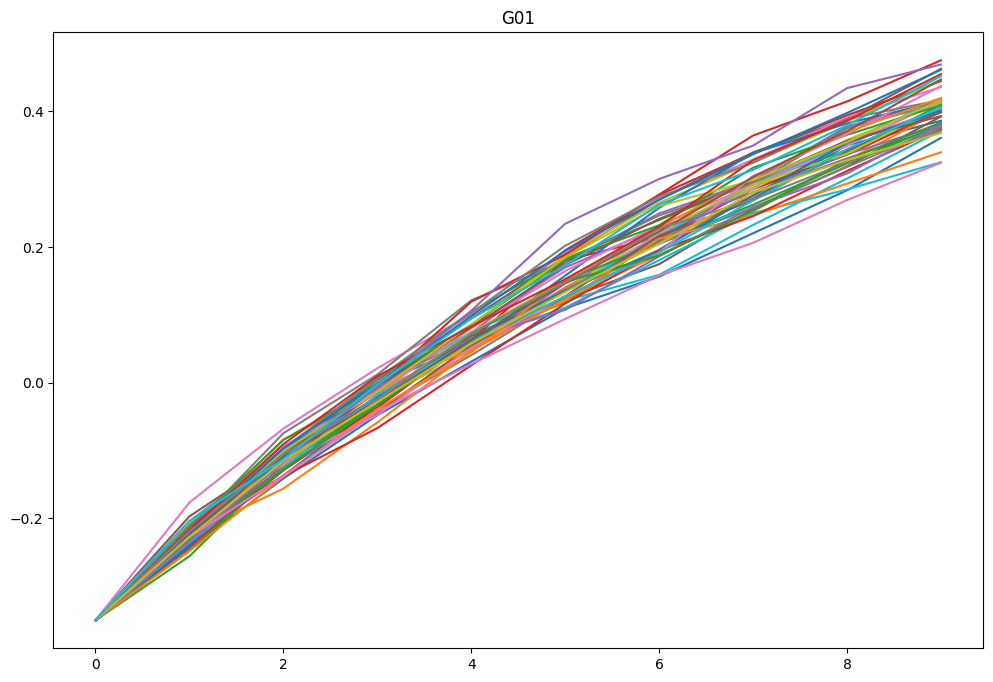

In [93]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G01_records):
    plt.plot(Gs, label=f"experiment {i}")
#plt.legend()
plt.title("G01")

Text(0.5, 1.0, 'G00')

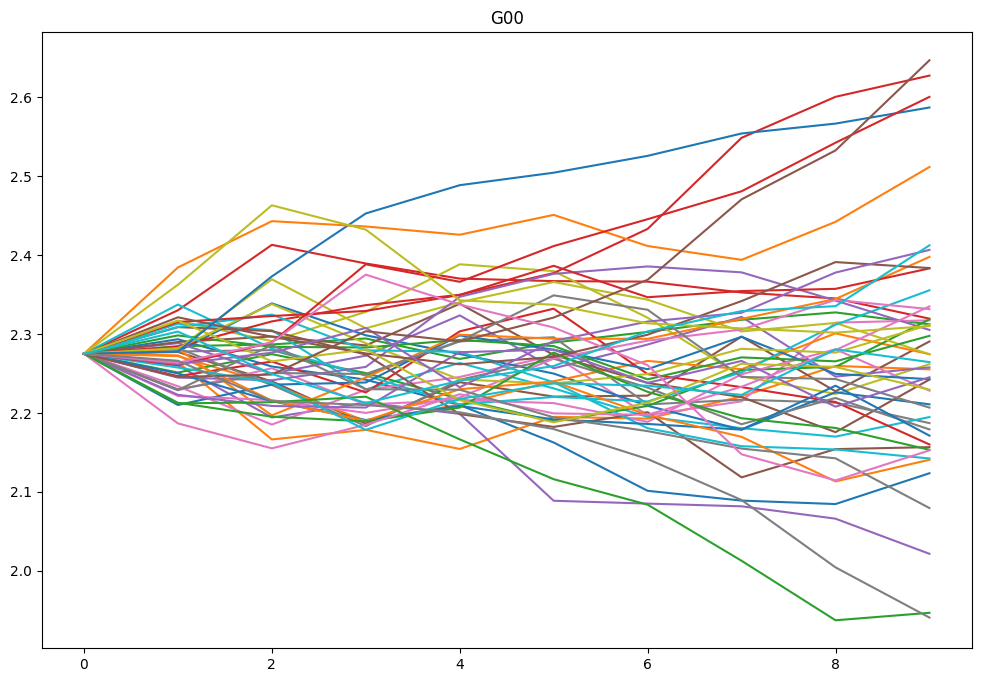

In [94]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G00_records):
    plt.plot(Gs, label=f"experiment {i}")
#plt.legend()
plt.title("G00")

Text(0.5, 1.0, 'G11')

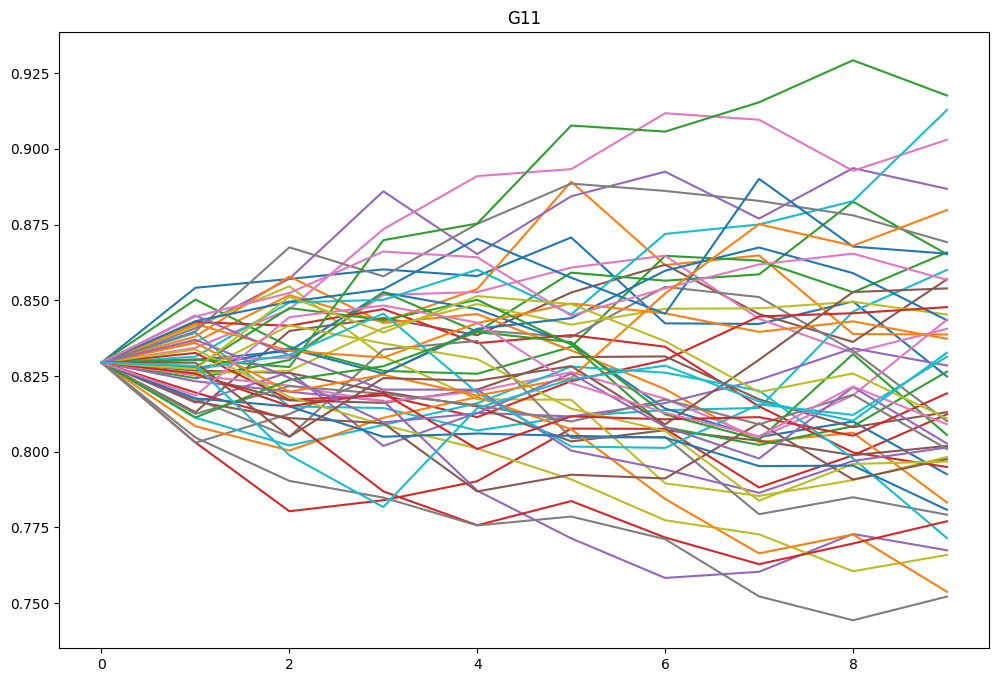

In [95]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G11_records):
    plt.plot(Gs, label=f"experiment {i}")
#plt.legend()
plt.title("G11")